Below is the code to make a library of charge signals throughout the detector using icpc_siggen source code for symmetric HPGe detectors. 

This code will create the library in a pkl file then proceed to open and plot specific waveforms. The signals can be adapted in the config file to include different variations of your choosing. 

In [1]:
import numpy as np
import pandas as pd   
import os 
import subprocess

home_dir='/global/homes/k/kbhimani/CPU-Net/data_emulation/'
siggen_dir= home_dir + 'icpc_siggen/'
det = "V06649A"

In [2]:
#import subprocess which is the package created for the fieldgen and siggen source code
#below is an example of running one of the config files
subprocess.run(f"cat {siggen_dir}config_files/{det}.config", shell=True).stdout

# V06649A configuration file for fieldgen/siggen
# all lengths are in mm
# format is <key_word> <value> # comment, with key_word starting at beginning of line

# general
verbosity_level      2   #  0 = terse, 1 = normal, 2 = chatty/verbose

# detector geometry
xtal_length         96.0   # z length
xtal_radius         40.45   # radius
top_bullet_radius    0   # bulletization radius at top of crystal
bottom_bullet_radius 0   # bulletization radius at bottom of BEGe crystal
pc_length            2   # point contact length
pc_radius            2.3   # point contact radius
bulletize_PC         0   # point contact hemispherical rather than cylindrical
wrap_around_radius  14   # wrap-around radius. Set to zero for ORTEC
ditch_depth          2   # depth of ditch next to wrap-around
ditch_thickness      3   # width of ditch next to wrap-around
hole_length         69.9   # length of hole, for inverted-coax style
hole_radius          5   # radius of hole, for inverted-coax style
hole_bullet_radius

In [3]:
import subprocess
import numpy as np
import pandas as pd
import os
import struct
wf_len = 1000
# Define constants and paths
home_dir = '/global/homes/k/kbhimani/CPU-Net/data_emulation/'
siggen_dir = os.path.join(home_dir, 'icpc_siggen/')
commands_file_path = os.path.join(siggen_dir, "my_stester_commands.txt")
os.chdir(siggen_dir)

phi = round(np.pi / 2, 3)
r = np.arange(0, 40.45, 0.1)
z = np.arange(0, 96.0, 0.1)
output_folder = os.path.join(siggen_dir, "data_emulation/waveforms/")

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Run mjdfieldgen to calculate and save the weighting potential
subprocess.run(f"{siggen_dir}/mjd_fieldgen {siggen_dir}/config_files/{det}.config", shell=True, check=False, stdout=subprocess.DEVNULL)

# Prepare for data collection
data_list = []

# Open the command file and write all simulation commands
with open(commands_file_path, "w") as f:
    f.write("cart \n")
    f.write("tau 0\n")
    f.write("dif 1\n")
    f.write("ccs 0.1\n")
    
    for i in r:
        for j in z:
            filename = f"normal_{i}_{phi}_{j}.spe"
            full_path = os.path.join(output_folder, filename)
            f.write(f"sig {i:.2f} {phi:.2f} {j:.2f} {full_path}\n")
    f.write("quit\n")

print("Command file written.")

# Run all simulations
print("Running simulations...")
result = subprocess.run(f"{siggen_dir}/stester {siggen_dir}/config_files/{det}.config < {commands_file_path}", shell=True, check=False, stdout=subprocess.DEVNULL)
print("Simulations completed with return code:", result.returncode)

# Read the generated waveform files
print("Processing waveform files...")
for i in r:
    for j in z:
        filename = f"normal_{i}_{phi}_{j}.spe"
        full_path = os.path.join(output_folder, filename)
        
        if os.path.exists(full_path):             
            try:       
                with open(full_path, 'rb') as file:
                    head = file.read(36)  # Skip header.
                    yraw = file.read(wf_len*4)  # Read waveform data.
                    wf = np.array(struct.unpack('f'*wf_len, yraw))
                data_list.append({'r': i, 'phi': phi, 'z': j, 'data_column': wf})
                os.remove(full_path)  # Delete the waveform file after reading
            # print(f"Processed and deleted: {full_path}")
            except Exception as e:
                # print(f"Error processing file {waveform_path}: {e}")
                continue
        # else:
            # print(f"File not found: {full_path}")

# Create DataFrame from collected data
results_df = pd.DataFrame(data_list)

# Save results to a pickle file and display the DataFrame
results_df.to_pickle(home_dir + 'output_dataframe.pkl')
df = pd.read_pickle(home_dir + 'output_dataframe.pkl')
print(df)


Command file written.
Running simulations...
Simulations completed with return code: 0
Processing waveform files...
           r    phi     z                                        data_column
0        0.0  1.571   2.0  [235.81141662597656, 526.297119140625, 651.911...
1        0.0  1.571   2.1  [256.18865966796875, 535.20654296875, 656.3875...
2        0.0  1.571   2.2  [273.3979187011719, 543.6134643554688, 660.630...
3        0.0  1.571   2.3  [287.6125793457031, 551.5781860351562, 664.664...
4        0.0  1.571   2.4  [298.9544677734375, 559.1694946289062, 668.522...
...      ...    ...   ...                                                ...
323320  39.5  1.571  94.5  [3.6136392736807466e-05, 0.000129226827993989,...
323321  39.5  1.571  94.6  [2.586509071988985e-05, 9.962331387214363e-05,...
323322  39.5  1.571  94.7  [1.644246731302701e-05, 7.064030069159344e-05,...
323323  39.5  1.571  94.8  [8.467700354231056e-06, 4.190548133919947e-05,...
323324  39.5  1.571  94.9  [1.8581189

In [4]:
len(df["data_column"][0])

1000

,r,z,data_column
0,0.0,2.0,"[235.81141662597656, 526.297119140625, 651.911..."
1,0.0,2.1,"[256.18865966796875, 535.20654296875, 656.3875..."
2,0.0,2.2,"[273.3979187011719, 543.6134643554688, 660.630..."
3,0.0,2.3,"[287.6125793457031, 551.5781860351562, 664.664..."
4,0.0,2.4,"[298.9544677734375, 559.1694946289062, 668.522..."
...,...,...,...
323320,39.5,94.5,"[3.6136392736807466e-05, 0.000129226827993989,..."
323321,39.5,94.6,"[2.586509071988985e-05, 9.962331387214363e-05,..."
323322,39.5,94.7,"[1.644246731302701e-05, 7.064030069159344e-05,..."
323323,39.5,94.8,"[8.467700354231056e-06, 4.190548133919947e-05,..."


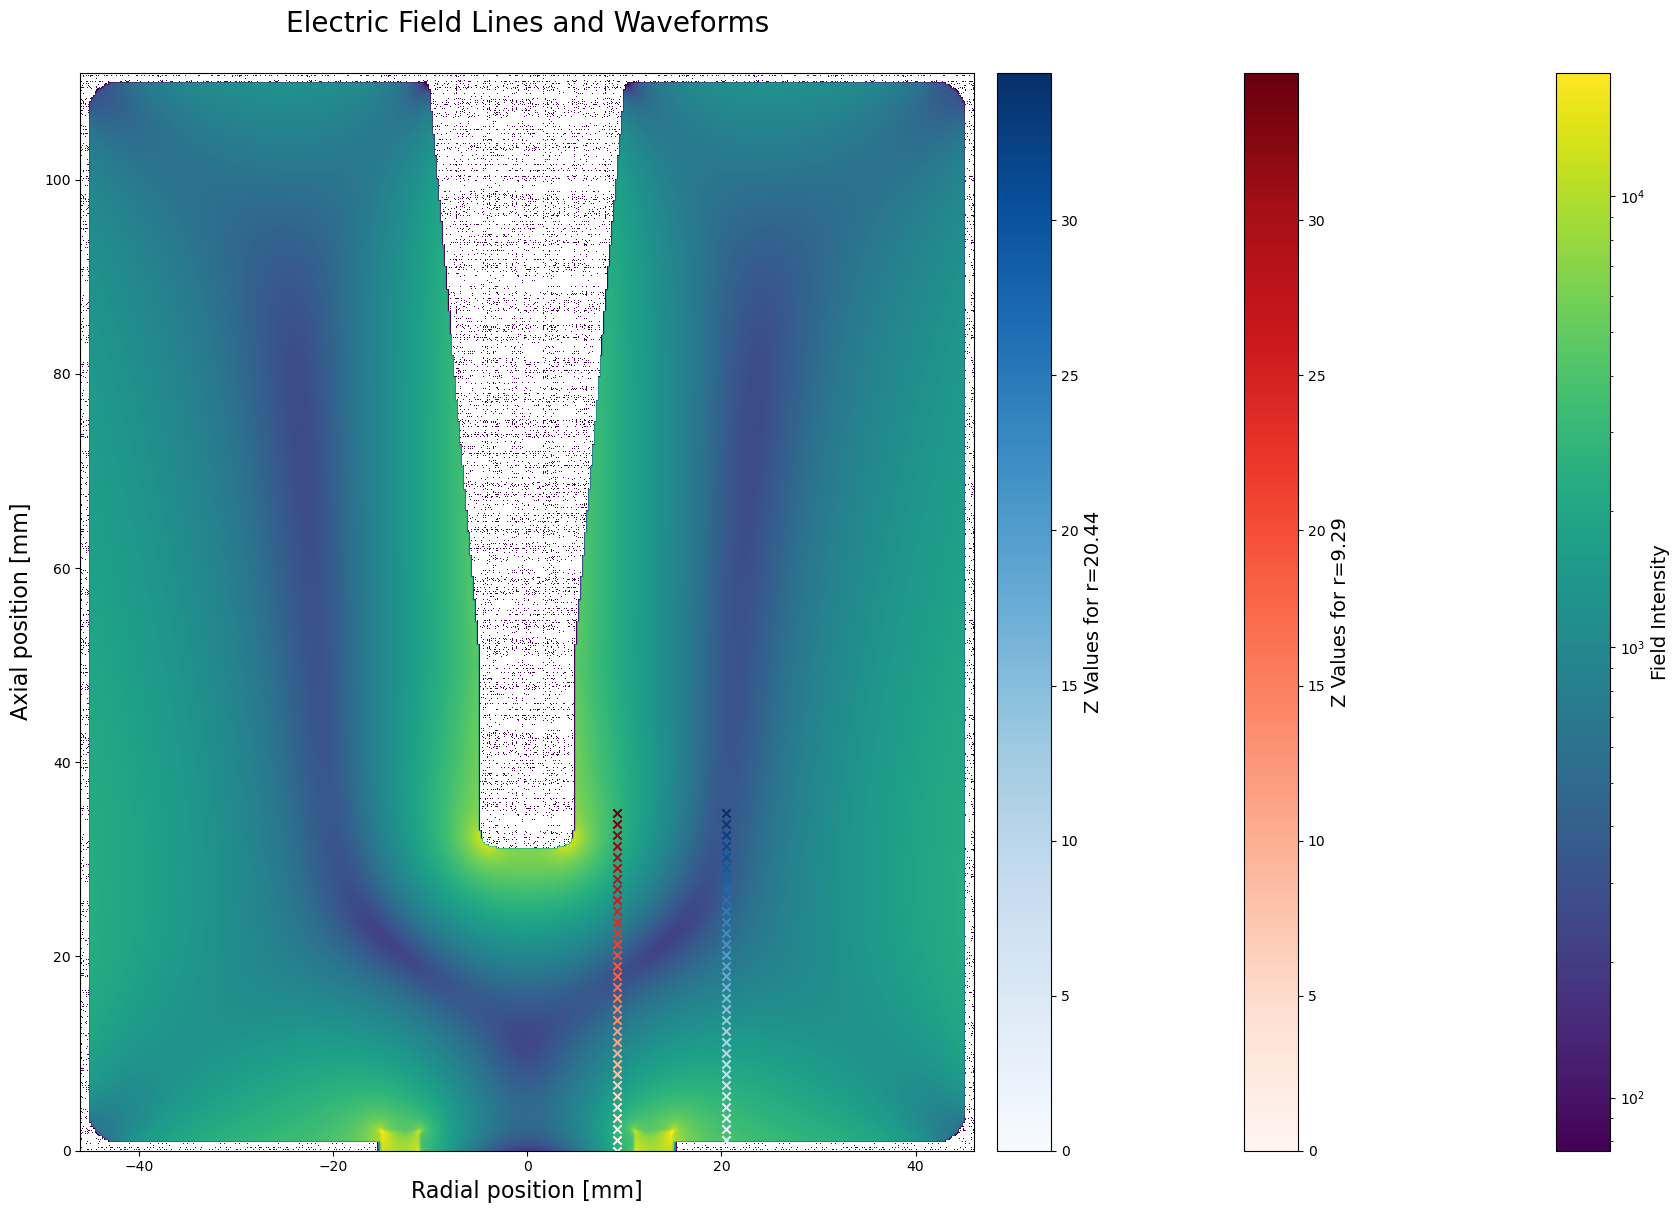

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Load the DataFrame from the pickle file
home_dir = '/global/homes/k/kbhimani/CPU-Net/data_emulation/'
df = pd.read_pickle(home_dir + 'output_dataframe.pkl')
df['r'] = df['r'].round(2)
df['z'] = df['z'].round(2)

# Display the DataFrame for debugging
df_rounded = df[['r', 'z', 'data_column']].copy()
display(df_rounded)

# Z values to be used for plotting
z_values = [0.00, 1.12, 2.24, 3.36, 4.48, 5.61, 6.73, 7.85, 8.97, 10.09, 11.21, 12.33, 13.45, 14.57, 15.70, 16.82, 17.94, 19.06, 20.18, 21.30, 22.42, 23.55, 24.67, 25.79, 26.91, 28.03, 29.15, 30.27, 31.39, 32.52, 33.64, 34.76]

def plot_combined(r_value1, r_value2, z_values, phi_value=np.pi/2):
    fig, ax1 = plt.subplots(figsize=(24, 14))
    
    # Part 1: Plot Electric Field Lines
    data = np.loadtxt("fields/ev_50372.dat")
    x = sorted(set(data[:,0]))
    y = sorted(set(data[:,1]))
    z = data[:,3]
    zvals = z.reshape(len(x), len(y))
    zvals[zvals < 0] = 0
    zvals = zvals.T
    zvals_neg = np.fliplr(zvals)
    zvals_full = np.hstack((zvals_neg, zvals))
    bounds = (-1 * max(x), max(x), min(y), max(y))
    
    img = ax1.imshow(zvals_full, norm=colors.LogNorm(), extent=bounds, origin="lower", cmap='viridis')
    
    # Scatter positions with color mapping for z values
    cmap1 = plt.get_cmap('Reds')
    cmap2 = plt.get_cmap('Blues')
    norm = colors.Normalize(vmin=min(z_values), vmax=max(z_values))
    
    for z_val in z_values:
        ax1.scatter(r_value1, z_val, color=cmap1(norm(z_val)), marker='x')
        ax1.scatter(r_value2, z_val, color=cmap2(norm(z_val)), marker='x')
    
    ax1.set_xlabel("Radial position [mm]", size=16)
    ax1.set_ylabel("Axial position [mm]", labelpad=8, size=16)
    ax1.set_title('Electric Field Lines and Waveforms\n', fontsize=20)
    cbar = fig.colorbar(img, ax=ax1, pad=0.01, fraction=0.2)
    cbar.set_label('Field Intensity', size=14)
    
    # Part 2: Plot Waveforms
    sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
    sm1.set_array([])
    sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
    sm2.set_array([])
    
    for z_val in z_values:
        filtered_df1 = df_rounded[(df_rounded['z'] == z_val) & (df_rounded['r'] == r_value1)]
        for _, row in filtered_df1.iterrows():
            y = row['data_column']
            x = np.arange(len(y))
            color = cmap1(norm(z_val))
            ax1.plot(x, y + z_val, color=color)  # Offset by z_val for visibility
    
        filtered_df2 = df_rounded[(df_rounded['z'] == z_val) & (df_rounded['r'] == r_value2)]
        for _, row in filtered_df2.iterrows():
            y = row['data_column']
            x = np.arange(len(y))
            color = cmap2(norm(z_val))
            ax1.plot(x, y + z_val, linestyle='--', color=color)  # Offset by z_val for visibility
    
    # Add color bars for z values
    cbar1 = fig.colorbar(sm1, ax=ax1, pad=0.01, fraction=0.2)
    cbar1.set_label('Z Values for r={}'.format(r_value1), size=14)
    cbar2 = fig.colorbar(sm2, ax=ax1, pad=0.02, fraction=0.2)
    cbar2.set_label('Z Values for r={}'.format(r_value2), size=14)
    
    plt.show()

plot_combined(r_value1=9.29, r_value2=20.44, z_values=z_values)
